## Worksheet 8

### Group 22 Eaton Heidegger and Shannon Schröder

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Computational Fluid Mechanics I
 ####  Non-linear advection: FD vs. FV

a) i) The solution at x/t can be written in the case of the shock forming situation ($u_L > u_R$) as : 

![image.png](./image.png)


![Screenshot 2025-05-20 114057.png](./burgersShock.png)

In general, in case of a shock, the left side is moving faster than the right, as given above: $u_L > u_R$. Therefore, characteristics converge, since each characteristic travels as speed u (and the left side is faster than the right) and the wavefronts 'crash' into each other. This leads to a formation of a shock, i.e. a discontinous jump in the solution. 


The conservation law in conservative form gives us the Rankine-Hugoniot jump condition across a shock moving at speed s:

$ s = \frac{f(u_L)-f(u_R)}{u_L-u_R} = \frac{1/2 u^2_L -1/2 u^2_R}{u_L-u_R} = \frac{u_L + u_R}{2} $

The Lax entropy condition $u_L > s > u_R$ selects the physical branch, so the self-similar solution is the two constant states separated by a shock moving at speed s:

Graphically, on the left plot, we can see that the line x = st splits the x-t diagram into two sections. To the left of the line $u=u_L$ and to the right $u = u_R$ 

On the right plot, we can see the discontinuity jump of the shock solution. On the left, we have $u_L = 1$ and then the shock line at x/t - $\zeta$ , which is the similarity variable. This is the graph of the self-similar solution $u= u(\zeta)$ against $\zeta = x/t$. The step is located at $\zeta = s$.

(We can check this with the flux a x=0, t=0.  Since the shock speed is s, we have to check wheter $0<s$  or larger s. At x=0, if $s>0$, then u(0,1) = $u_L$. If $s<0$, then u(0,1) = $u_R$.)


a) ii) The solution can be written in the case of rarefaction wave as: 

![u(x,t)](./u_rarefaction.png)

with the flux location x=0 given by f(u(0,1))

![Screenshot 2025-05-20 114103.png](./BurgersRarefaction.png)

In the Rarefaction case, the left side moves faster than the right: $u_L < u_R$. The characteristic is spread out, as we can see in the left plot. The flow 'stretches', leading to a rarefaction wave. The solution therefore smootly interpolates bewteen $u_L$ and $u_R$. ( In other words the characteristics diverge and leave a gap that must be filled by the continuous branch!) 


If we apply the method of characteristics for burgers equation :

$\frac{dx}{dt} = u(x,t)$

The initial condition is discontinous, so we assume a self-similar solution: 

$u(x,t) = u(\zeta)$, where $\zeta = \frac{x}{t}$ (as in plot of i))

We insert this into the conseervative form from the exercise sheet: 

$\delta_t u + \delta_x f(u) = 0$, with $f(u) = \frac{1}{2} u^2$, 

we get: 

$\delta_t u + \delta_x \left(\frac{1}{2}u^2 \right) = 0 
\rightarrow - \frac{\zeta}{t}u'(\zeta) + \frac{1}{t} u(\zeta) u'(\zeta) = 0 
\rightarrow u'(\zeta) (-\zeta + u(\zeta)) = 0 $

**This gets us a gap that must be filled by the continous branch: $u(\zeta) = \zeta$**


Therefore the solution is  within the fan as above: 

$u(x,t) = \frac{x}{t}$, for $u_L < \frac{x}{t} < u_R$ Which then yields the above solution : a continous profile


The fan occupies the sector bounded by the two extreme characteristic speeds 
uL and uR (left plot). On the right plot, there is an alternative 'shock' with uL < uR which would violate the entropy condition and is therefore inadmissible. 
 

#### b i) Use the supplied notebook burgers fvm.ipynb and implement the missing flux functions for the finite volume method based on the solution to the Riemann problem given in a) for x ∈[0,1].

Finite Volume Method: 
- Integrated the conservation law over each cell
- requires numerical fluxes at cell interfaces to update the cell-averaged values 

The idea is that for a finite-volume interface we need the exact flux that crosses the line x = 0 during the time step. Because the solution of the Riemann poblem is self-similar, all that matters is the value it takes at the similarity point $\zeta = \frac{x}{t} = 0 = u $.

The exact numerical flux is then simply $F = f(u) = \frac{1}{2} u^2$
Therefore to compute the numerical flux at an interface, we solve the Rieman problem, by evaluating u(0,1), which is the state at the interface after a unit time and compute the flux f(u(0,1)).


We have:
1. the shock, here u(x,t) =$u_L$, if x/t < s, $u_R$ otherwise, with s = ($u_L +u_R / 2$). Therefore, we have for the shock ($u_L > u_R$):
- if s > 0 (>$\zeta =0$) : u = $u_L$

2. Rarefaction (if $u_L < u_R$), at x0, which gives us: 

- u(0,t) = $u_L$, if $u_L > 0  $ (left)
- u(0,t) = $u_R$, if $u_R < 0 $ (right)
- u(0,t) = 0, if $u_L \leq 0 \leq u_R $ (middle)


In [3]:
# Flux function
def flux(u):
    return 0.5 * u**2

# Riemann solver (Godunov flux for Burgers' equation)
def godunov_flux(uL, uR):
    if uL > uR:
        # Shock
        s = 0.5 * (uL + uR)
        u = uL if s > 0 else uR
        
        return flux(u)
    else:
        # Rarefaction
        if uL > 0: 
            u = uL
        elif uR < 0:
            u = uR  
        else:
            u = 0.0 
        return flux(u)

# Initial condition: step function
def initial_condition(x, uL, uR):
    return np.where(x < 0.5, uL, uR)

# Finite volume solver
def burgers_fvm(uL, uR, N=100, CFL=0.9, T=0.3):
    x = np.linspace(0, 1, N)
    dx = x[1] - x[0]
    u = initial_condition(x, uL, uR)
    
    t = 0.0
    while t < T:
        # Compute max speed for CFL condition
        max_speed = np.max(np.abs(u))
        dt = CFL * dx / max_speed 
        if t + dt > T:
            dt = T - t

        # Compute numerical fluxes
        fluxes = np.zeros(N+1)
        for i in range(1, N):
            fluxes[i] = godunov_flux(u[i-1], u[i])

        # Update solution
        u[1:-1] -= dt/dx * (fluxes[2:-1] - fluxes[1:-2])


        t += dt
        #print(f"Time: {t:.2f}, dt: {dt:.4f}")


    return x, u


ii) Plot the solution for the case of a shock wave and a rarefaction wave: (1) showing u as a function of x at a few select times

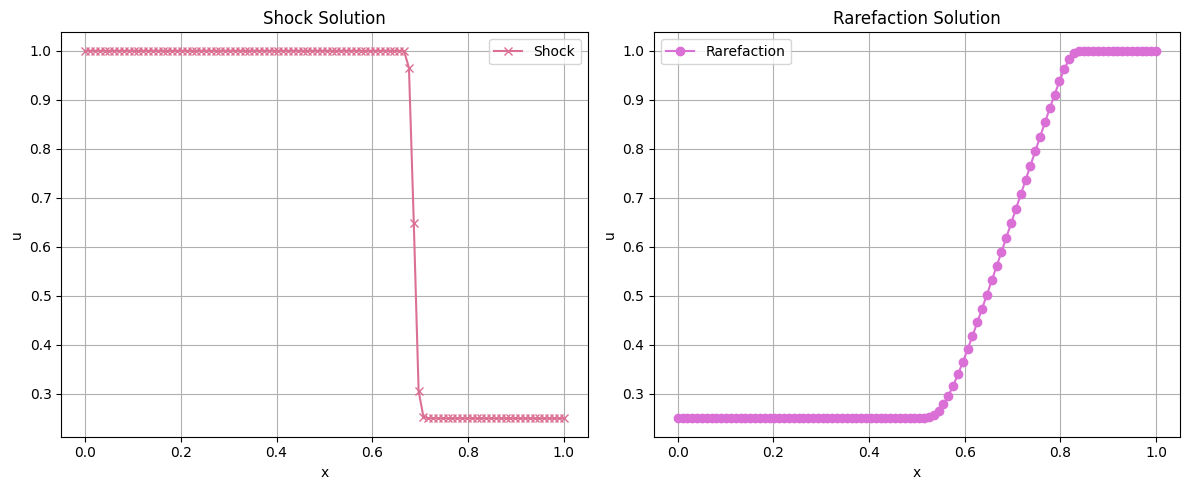

In [4]:
# Setup parameters : 
T = 0.3
N = 100

# Shock wave initial condition
uLs = 1.0
uRs = 0.25
xs, us = burgers_fvm(uLs, uRs, N=100)

# Rarefaction wave initial condition
uLr = 0.25
uRr = 1
xR, uR = burgers_fvm(uLr, uRr, N=100)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(xs, us, 'x-', label='Shock', color='palevioletred')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Shock Solution')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(xR, uR, 'o-',label='Rarefaction', color='orchid')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Rarefaction Solution')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

Left plot: 
We see the sharp discontinuity where where the shock is and the left side faster than the right.

Right plot: 
We see first the left side slower than the right and a more continous rise, where the fan is. 

 iii) Plot the solution for the case of a shock wave and a rarefaction wave:showing the full space-time diagram of the solution, i.e. as an image with t on the x-axis and x on the y-axis, and the colour indicating the value of u. 

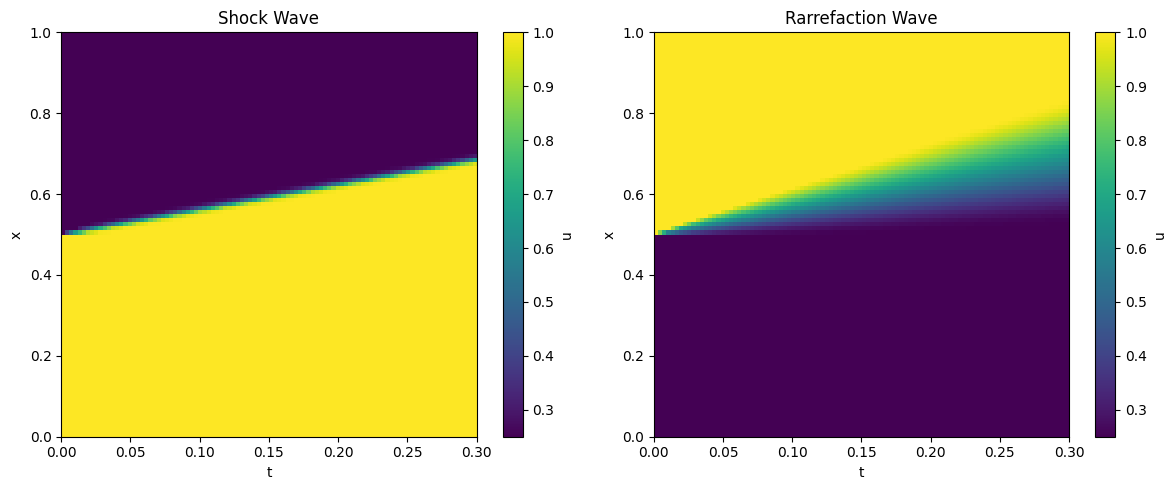

In [5]:
t = np.linspace(0, T, N)

u_space_time_S = np.zeros((N, N))
u_space_time_R = np.zeros((N, N))
for j in range(N):
    u_space_time_S[:, j] = burgers_fvm(uLs, uRs, N=N, T=t[j])[1]
    u_space_time_R[:, j] = burgers_fvm(uLr, uRr, N=N, T=t[j])[1]


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(u_space_time_S, extent=[t[0], t[-1], xs[0], xs[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Shock Wave')


plt.subplot(1, 2, 2)
plt.imshow(u_space_time_R, extent=[t[0], t[-1], xR[0], xR[-1]], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Rarrefaction Wave')
plt.tight_layout()
plt.show()

In the left panel, the transition is sharp and the scheme captures the shock clearly, as we would expect it.
In the right panel, we see the diffuse transition region, as predicted by the Rarrefaction case, where u smootly transitions from left to right value.

 ### 2. Full hydro equations in 1D– Shock tubes and a supernova explosion

ai)  Compute solutions to the following three Riemann problems with the  initial conditions and final times for $\gamma = 1.4$ (air)

In [6]:

def prim_to_cons(Q, gamma ):
    """
    Return an array of conserved hydro variables given an array of primitive variables
    @param Q : primitive variables (Nx3: rho, v, P)
    @return U: conserved variables (Nx3: rho, rhov, E)
    """
    U = np.zeros_like(Q)
    U[:,0] = Q[:,0]
    U[:,1] = Q[:,0] * Q[:,1]
    U[:,2] = Q[:,2]/(gamma-1) + 0.5 * Q[:,0] * Q[:,1]**2
    return U

def cons_to_prim(U, gamma ):
    """
    Return an array of primitive hydro variables given an array of conserved variables
    @return Q : primitive variables (Nx3: rho, v, P)
    @param U: conserved variables (Nx3: rho, rhov, E)
    """
    Q = np.zeros_like(U)
    Q[:,0] = U[:,0]
    Q[:,1] = U[:,1]/U[:,0]
    Q[:,2] = (gamma-1)*(U[:,2] - 0.5 *U[...,1]**2/U[...,0])
    return Q

def get_flux_from_U( U, gamma ):
    """
    Compute the flux vector from the conserved variables.
    @param U: Conserved variables (Nx3: rho, rhov, E)
    @param gamma: Adiabatic index
    @return F: Flux vector (Nx3: rho*v, rhov*v + P, (E+P)*v)
    """
    F = np.zeros_like(U)
    P = (gamma-1) * (U[:,2] - 0.5 * U[:,1]**2 / U[:,0])
    v = U[:,1] / U[:,0]
    F[:,0] = U[:,0] * v
    F[:,1] = U[:,1] * v + P
    F[:,2] = (U[:,2]+P) * v
    return F

def get_cs_and_v_from_U( U, gamma ):
    """
    Compute the sound speed and velocity from conserved variables.
    @param U: Conserved variables (Nx3: rho, rhov, E)
    @param gamma: Adiabatic index
    @return cs: Sound speed
    @return v: Velocity
    """
    v = U[:,1] / U[:,0]
    cs = np.sqrt( gamma*(gamma-1)*(U[:,2]/U[:,0]-0.5*v**2) )
    return cs, v

In [7]:

def get_conservative_update( U, dx, gamma, CFLfac ):
    """
    Compute the conservative update vector and the maximum allowed time step. Assumes periodic BCs.
    This function uses the HLL (Harten-Lax-van Leer) Riemann solver to compute the fluxes.

    Parameters:
    U (numpy.ndarray): Conserved variables (Nx3: rho, rhov, E).
    dx (float): Spatial resolution (cell width).
    gamma (float): Adiabatic index.
    CFLfac (float): CFL factor for time step calculation.

    Returns:
    dU (numpy.ndarray): Update vector for conserved variables (Nx3).
    dtmax (float): Maximum allowed time step based on CFL condition.
    """
    # compute the maximal allowed time step
    cs,v = get_cs_and_v_from_U( U, gamma )
    dtmax = CFLfac * dx / np.max( (np.abs(v)+np.abs(cs)).flatten() )

    # compute left and right state (piecewise constant approx.)
    # assume periodic BCs here, we'll fix this later in case we need
    # to use non-periodic BCs
    Uleft = U                     # U_L = U_i
    Uright = np.roll(U,-1,axis=0) # U_R = U_{i+1}

    # compute left and right flux from left and right states
    # assume periodic BCs here
    Fleft = get_flux_from_U( Uleft, gamma )   # Fleft = F( U_L )
    Fright = get_flux_from_U( Uright, gamma ) # Fright = F( U_R )

    # compute maximum signal speeds
    Sleft = np.abs(v) + np.abs(cs)
    Sright = np.roll(Sleft,-1)
    Sstar = np.max((Sleft,Sright))

    # compute HLL interface flux
    FHLL = np.zeros_like(U)
    for i in range(3): # loop over conserved variables
        FHLL[:,i] = 0.5*(Fleft[:,i]+Fright[:,i])-0.5 * Sstar * (Uright[:,i]-Uleft[:,i])

    # compute net flux in and out of cell due to left and right boundary
    dU = -( FHLL - np.roll(FHLL,+1,axis=0)) / dx

    return dU, dtmax

In [8]:
def solve_hydro1D( Q_ini, tend, gamma = 5/3, CFLfac = 0.95):
    """
    Solve the 1D hydrodynamics equations using the Godunov method with the HLL Riemann solver.

    Parameters:
    Q_ini (numpy.ndarray): Initial conditions for the primitive variables (Nx3: rho, v, P).
    tend (float): End time for the simulation.
    gamma (float, optional): Adiabatic exponent. Default is 5/3.
    CFLfac (float, optional): CFL factor for time step calculation. Default is 0.95.

    Returns:
    numpy.ndarray: Final primitive variables (Nx3: rho, v, P) at time `tend`.
    """
    
    N = Q_ini.shape[0]
    dx = 1/N
    U = prim_to_cons(Q_ini, gamma) # convert to conserved variables

    t = 0.0 # time counter
    step = 0 # step counter
    exceeded = False
    while t<tend:
        # compute the update vector for the primitive variables
        dU, dtmax = get_conservative_update(U, dx, gamma, CFLfac)

        # we use constant Dirichlet BCs, so we set the first and last flux to zero
        dU[0,:] = 0
        dU[-1,:] = 0
        
        # compute the time step we will use for this step
        dt = np.min((CFLfac*dtmax, tend-t))
            
        # actually perform the update
        U += dt*dU
        t += dt
        step += 1
        print('Step %i, t = %.2f, dt = %.2f' % (step, t, dt), end='\r')

    print('\n Done in %i steps'%step)
    return cons_to_prim(U, gamma) # return primitive variables

Problem 1 

In [ ]:
# define initial conditions for the Sod shock tube
Np = 256
rho_L = 1.0
rho_R = 0.125
v_L = 0.0
v_R = 0.0
P_L = 1.0
P_R = 0.1
t_end = 0.25

x = np.linspace(0,1,Np)
Q_ini = np.zeros((x.shape[0],3))
Q_ini[:,0] = np.where(x<0.5, rho_L, rho_R) # density
Q_ini[:,1] = np.where(x<0.5, v_L, v_R) # velocity
Q_ini[:,2] = np.where(x<0.5, P_L, P_R ) # pressure

In [10]:
# Compute the solution
Q = solve_hydro1D( Q_ini, t_end, gamma=1.4, CFLfac=0.95)

Step 154, t = 0.25, dt = 0.00
 Done in 154 steps


In [11]:
import riemann_exact as riemann

sol = riemann.solve_riemann_exact( left_state=(rho_L, v_L, P_L), right_state=(rho_R, v_R, P_R), gamma=1.4, t=t_end, npts = 1000)

Text(0.5, 0, 'x')

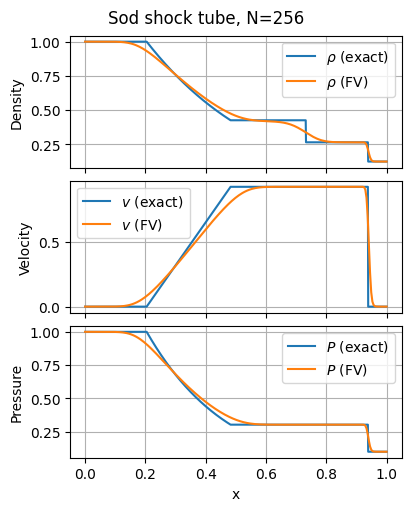

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(4, 5), sharex=True, layout='constrained' )

ax[0].plot(sol['x'], sol['rho'], '-', label='$\\rho$ (exact)')
ax[0].plot(x, Q[:,0], '-', label='$\\rho$ (FV)')
ax[0].set_ylabel('Density')

ax[1].plot(sol['x'], sol['v'], '-', label='$v$ (exact)')
ax[1].plot(x, Q[:,1], '-', label='$v$ (FV)')
ax[1].set_ylabel('Velocity')

ax[2].plot(sol['x'], sol['P'], '-', label='$P$ (exact)')
ax[2].plot(x, Q[:,2], '-', label='$P$ (FV)')
ax[2].set_ylabel('Pressure')

for a in ax:
    a.legend()
    a.grid()
plt.suptitle(f'Sod shock tube, N={Np}')
ax[-1].set_xlabel('x')

ii)  Make plots comparing the exact solution to your numerical solution at the final time in each of the three primitive variables

iii) Show also a space-time diagram of the solution numerical solution over the time span $[0,t_{end}]$ for each of the three problems.

iiii)  Explain the differences
 between the three problems and how they are reflected in the solution. Can you identify
 the different wave structures (shock waves, rarefaction fans, contact discontinuities) in the
 solution?